# Assignment 7: Conjugate Gradient Descent

In this homework, we will implement the conjugate graident descent algorithm. While you should nearly always use an optimization routine from a library for practical data analyiss, this exercise is useful because it will make concepts from multivariatble calculus and linear algebra covered in the lectrures concrete for you. Also, it brings you up the learning curve for the implementaiton of more complex algorithms than the ones you have been exposed to so far.

Note: The exercise assumes that we can calculate the gradient and Hessian of the fucntion we are trying to minimize. This can be computationally expensive or not even possible for soeme functions. Approximate methods can then be used; we do not go into such complexities here.

**Conjugate gradient descent**

We want to implement the line search method 

$$ 
x_{k+1} = x_k + \alpha_k p_k
$$

where $\alpha_k$ is the step size and $p_k$ is the search direction. 

In particular, we want the search directions $p_k$ to be *conjugate*, as this will allow us to find the minimum in $n$ steps for $x \in \mathbb{R}^n$ if $f(x)$ is a quadratic function.

The following exercises will unpack this:

- What quadratic functions are
- What conjugate vectors are
- How to find conjugate vectors by Gram-Schmidt process
- How to find the step size $\alpha_k$

and finally wrap them all into a conjugate gradient algorithm.

**Quadratic function surfaces**

Recall that our objective is to minimize a scalar valued function which maps $\mathbb{R}^n \mapsto \mathbb{R}$, for example, a log likelihoood function (for MLE) or unnormalized posterior distribution (for MAP). Geometrically, we are tring to find the value of the lowest point of some surface. The conjugate gradient algorihtm assumes that the surface can be approximated by the quadratic expression (say, by using a Taylor series expansion about $x$)

$$
f(x) = \frac{1}{2}x^TAx - b^Tx + c
$$

and that 

$$
\nabla f = Ax - b = 0
$$

at the minimum (if A is positive definite). Note that $A$ is a matrix, $b$ is a vector, and $c$ is a scalar.  Also, note that the matrix $A$ is the Hessian of the quadratic function.For simplicity, we'll work in $\mathbb{R}^2$ so we can visualize the surface, so that $x$ is a 2-vector.

Note: A **form** is a polynomial function where every term has the same degree - for example, $x^2 + 2xy + y^2$ is a quadratic form, whcih can be rewritten as 
$$
\begin{pmatrix}
x & y
\end{pmatrix}
\begin{pmatrix}
    1 & 1\\
    1 & 1
\end{pmatrix}
\begin{pmatrix}
x \\
y
\end{pmatrix}
$$

That is, $x^TAx$ is a quadratic form.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la

**Exercise 1 (20 points)** 

We will work with function $f_1$

$$
f1(x) = \frac{1}{2} x^T \pmatrix{1 & 0 \\ 0 & 1}x
$$

and function $f_2$

$$
f2(x) = \frac{1}{2} x^T \pmatrix{1 & 0 \\ 0 & 3}x
$$

- Plot the labeled contours of the quadratic functions
- Use a `streamplot` to show the gradient vector field of the above quadratic functions.

(-10.000000000000004, 10.000000000000043, -10.0, 10.000000000000046)

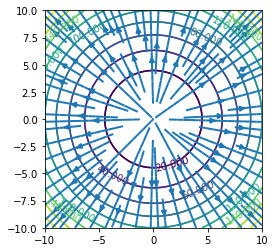

In [2]:
def f1(x):
    return (x[0]**2+x[1]**2)/2

def grad1(x):
    return np.array([x[0],x[1]]).reshape([-1,1])

def hess1(x):
    return np.array([
        [1,0],
        [0,1]
    ])

x1 = np.linspace(-10,10,100)
y1 = np.linspace(-10,10,100)
X1, Y1 = np.meshgrid(x1,y1)
Z1 = X1**2 + Y1**2
plt.contour(X1,Y1,Z1,10)
plt.clabel(plt.contour(X1,Y1,Z1,10))
plt.streamplot(X1, Y1, X1, Y1, linewidth=2, cmap=plt.cm.autumn)
plt.axis('square')


(-10.000000000000004, 10.000000000000043, -10.0, 10.000000000000046)

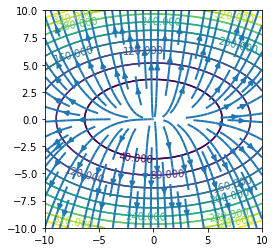

In [3]:
def f2(x):
    return (x[0]**2+3*(x[1]**2))/2

def grad2(x):
    return np.array([x[0],3*x[1]]).reshape([-1,1])

def hess2(x):
    return np.array([
        [1,0],
        [0,3]
    ])

x2 = np.linspace(-10,10,100)
y2 = np.linspace(-10,10,100)
X2, Y2 = np.meshgrid(x2,y2)
Z2 = X2**2 + 3*(Y2**2)
plt.contour(X2,Y2,Z2,10)
plt.clabel(plt.contour(X2,Y2,Z2,10))
plt.streamplot(X2, Y2, X2, 3*Y2, linewidth=2, cmap=plt.cm.autumn)
plt.axis('square')


**Gram-Schmidt**

The way to numerically find conjugate vectors is to use the Gram-Schmidt process. Here, instead of the usual projection 

$$
\text{proj}_u(v) = \frac{u \cdot v}{u \cdot u} \, u
$$

we use the generalized projection
$$
\text{proj}_u(v) = \frac{uA^Tv}{uA^Tu} \, u
$$

**Exercise 2 (30 points)**

The vectors $u$ and $v$ are orthogonal i.e. $u^Tv = 0$ and conjugate with respect to $A$ if $u^TAv = 0$. The geometric intuition for conjugate vecrors $u$ and $v$ is that $u$ and $v$ would be orthogonal if we stretched the contour plots so that it became isotropic (same in all directions, just like when A=𝟙). Write a Gram-Schmidt function to find orthogonal and conjuate vectors with the following signature

```python
def gram_schmidt(U, inner):
    """Return an orthogonal matrix.
    
    U is a matrix of (column) vecotrs.
    inner is a function that calculates the inner product.
    
    Returns an orthogonal matrix of the same shape as U.
    """
```

Use this function and the appropiate inner product to plot

- An orhtogonal set of basis vectors for $f_1$
- A conjugate set of basic vectors for $f_2$ 

where the first basis vector is to parallel to $\pmatrix{1 \\ 1}$.

In [4]:
def inner(u,A,v):
    return u@A.T@v
 
def gram_schmidt(U, inner, A):
    row_vecs = U.T
    V = np.zeros([row_vecs.shape[0],row_vecs.shape[1]])
    V[0,:] = row_vecs[0,:]
    for i in range(1,row_vecs.shape[0]):
        v = row_vecs[i,:].astype('float64')
        for j in range(i):
            u = V[j,:].astype('float64')
            proj = ((inner(u,A.T,v)/inner(u,A.T,u))*u).astype('float64')
            v -= proj
        V[i,:] = v
    return V.T

In [5]:
#The orhtogonal set of basis vectors for  f1
U = np.array([[2,2],[5,9]]).T
A1 = np.array([[1,0],[0,1]])
gram_schmidt(U, inner,A1)

array([[ 2., -2.],
       [ 2.,  2.]])

In [6]:
#the conjugate set of basic vectors for  f2
A2 = np.array([[1,0],[0,3]])
gram_schmidt(U, inner,A2)

array([[ 2., -3.],
       [ 2.,  1.]])

In [7]:
def plot_vectors(vs):
    """Plot the vectors vs."""
    for v in vs:
        plt.arrow(0, 0, v[0], v[1], head_width=0.5, head_length=0.5)

(-10.0, 10.0, -10.0, 10.0)

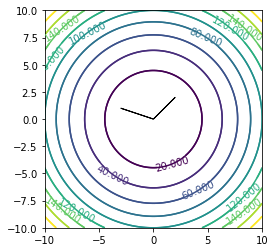

In [8]:
xc = np.linspace(-10,10,100)
yc = np.linspace(-10,10,100)
Xc, Yc = np.meshgrid(xc,yc)
Zc = Xc**2 + Yc**2
plt.contour(Xc,Yc,Zc,10)
plt.clabel(plt.contour(Xc,Yc,Zc,10))
plt.arrow(0,0,2,2)
plt.arrow(0,0,-3,1)
plt.axis('square')

**Exercise 3 (20 points)**

We now need to find the "step size" $\alpha$ to take in the direction of the search vector $p$. We can get a quadratic approximation to a general nonliner function $f$ by taking the Taylor series in the driection of $p$

$$
f(x + \alpha p) = f(x) + \alpha [f'(x)]^T p + \frac{\alpha^2}{2} p^T f''(x) p
$$

Find the derivative with respect to $\alpha$ and use this to find the optimal value for $\alpha$ with respect to the quadratic approcimaiton. 

* Write the derivation of the optimal step size $\alpha$ using LaTeX in a Markdown cell.
* Write a funciton that returns $\alpha$ for a quadratic funciton with the following signature

```python
def step(x, p, A, b):
    """Returns the optimal step size to take in line search on a quadratic.
    
    A and b are the coefficients of the quadartic expression 
    $$
    f(x) = \frac{1}{2}x^TAx - b^Tx + c
    $$
    p is the search direction
    x is the current location
    """
```

In [9]:
from IPython.display import Latex
Latex(r"$f'(α)=[f'(x)]^Tp+αp^Tf''(x)p$")

<IPython.core.display.Latex object>

In [10]:
#let f'(α) to be 0
Latex(r"$∵[f'(x)]^Tp+αp^Tf''(x)p=0$")

<IPython.core.display.Latex object>

In [11]:
Latex(r"$∴α=-\frac{[f'(x)]^Tp}{p^Tf''(x)p}$")

<IPython.core.display.Latex object>

In [12]:
#f(x) = \frac{1}{2}x^TAx - b^Tx + c
Latex(r"$∴α-\frac{(Ax-b^T)p}{p^TA}=\frac{b-Ax}{p^TAp}$")

<IPython.core.display.Latex object>

In [13]:
#α function
def step(x,p,A,b):
    return ((b-A@x).T@p)/(p.T@A@p)

**Line search**

We now know how to find a search direction $p_k$ - this is a vector that is conjugate to the previous search direction. The first search direction is usually set to be the gradient. Next we need to find out how far along $p_k$ we need to travel, i.e., we need to find $\alpha_k$. First we take a Taylor expansion in the direction of $p$

$$
f(x + \alpha p) = f(x) + \alpha [f'(x)]^T p + \frac{\alpha^2}{2} p^T f''(x) p
$$

followed by finding the derivative with respect to $\alpha$

$$
\frac{d}{d\alpha} f(x + \alpha p) = [f'(x)]^T p + \alpha p^T f''(x) p
$$

Solvign for $\frac{d}{d\alpha} f(x + \alpha p) = 0$, we get

$$
\alpha = - \frac{[f'(x)]^T p}{p^T f''(x) p} \\
= - \frac{\nabla f^T p}{p^T A p} \\
= \frac{(b - Ax)^T p}{p^T A p}
$$



**Exercise 4 (30 points)**

Implement the conjugate grdient descent algorithm with the following signature

```python
def cg(x, A, b, c, max_iter=100, tol=1e-3):
    """Conjugate gradient descent on a quadratic function surface.
    
    x is the starting position
    A, b and c are the coefficients of the quadartic expression 
    $$
    f(x) = \frac{1}{2}x^TAx - b^Tx + c
    $$
    max_iter is the maximum number of iterations to take
    tol is the tolerance (stop if the length of the gradient is smaller than tol)

    Returns the number of steps taken and the list of all positions visited.
    """
```

- Use cg to find the minimum of the funciton $f_2$ from Exercise 1, starting from $\pmatrix{6 \\ 7}$.

- Plot the contour of the funciton f and the trajectory taken from the inital starting poitn $x$ to the final position, inlcuding all the intermediate steps. 

We are not particularly concerned about efficiency here, so don't worry about JIT/AOT/C++ level optimization. 

In [14]:
#minimum of f2
def cg(x, A, b, c, max_iter=100, tol=1e-3):
    steps = [x]
    i = 0
    r = b - A @ x
    d = r
    deltanew = r.T @ r
    delta0 = deltanew
    #print(deltanew)
    while i < max_iter and deltanew > tol**2:
        alpha = float(deltanew/float(d.T @ (A@d)))
        x = x + alpha*d
        steps.append(x)
        r = b - A@x
        deltaold = deltanew
        deltanew = r.T @ r
        beta = float(deltanew / float(deltaold))
        d = r+beta*d
        i+=1
    return i,steps

x = np.array([6,7])
A = np.array([[1,0],[0,3]])
b = np.zeros(2)
c = 0
m,steps=cg(x,A,b,c)

In [15]:
m

2

In [16]:
steps

[array([6, 7]),
 array([ 3.89403974, -0.37086093]),
 array([4.44089210e-16, 2.22044605e-16])]

In [17]:
def contoursteps(x1, x2, zs, steps=None):
    fig = plt.figure(figsize=(6,6))
    cp = plt.contour(x1, x2, zs, 10)
    plt.clabel(cp, inline=1, fontsize=10)
    if steps is not None:
        steps = np.matrix(steps)
        plt.plot(steps[:,0], steps[:,1], '-o')
    fig.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


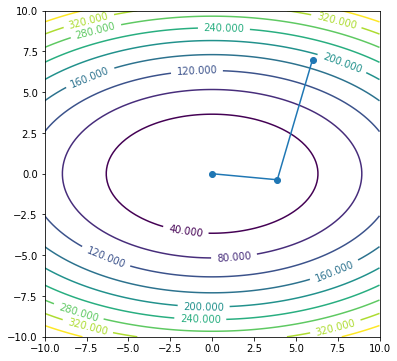

In [19]:
x2_new = np.linspace(-10,10,100)
y2_new = np.linspace(-10,10,100)
X2_new, Y2_new = np.meshgrid(x2_new,y2_new)
Z2_new = X2_new**2 + 3*(Y2_new**2)
contoursteps(X2_new,Y2_new,Z2_new,steps)